In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

In [2]:
def read_results(prefix, n_params):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+'data/bestfit_m_spec.pkl')
    d_spec = af.pickle_load(prefix+'data/d_spec.pkl')

    LogLike = af.pickle_load(prefix+'data/bestfit_LogLike.pkl')

    int_contr_em           = np.load(prefix+'data/bestfit_int_contr_em.npy')
    int_contr_em_per_order = np.load(prefix+'data/bestfit_int_contr_em_per_order.npy')
    int_opa_cloud          = np.load(prefix+'data/bestfit_int_opa_cloud.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, bestfit_params


res = read_results(
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_186/test_', n_params=30
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_20/test_', n_params=20
    #prefix='./retrieval_outputs/DENIS_J0255_retrieval_outputs_187/test_', n_params=33
    prefix='./retrieval_outputs/DENIS_J0255_nominal_5/test_', n_params=32
    )
posterior_1, bestfit_1, PT_1, Chem_1, int_contr_em_1, int_contr_em_per_order_1, int_opa_cloud_1, m_spec_1, d_spec_1, LogLike_1, bestfit_params_1 = res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_', n_params=29
    )
posterior_2, bestfit_2, PT_2, Chem_2, int_contr_em_2, int_contr_em_per_order_2, int_opa_cloud_2, m_spec_2, d_spec_2, LogLike_2, bestfit_params_2 = res

res = read_results(
    prefix='./retrieval_outputs/DENIS_J0255_chem_eq_wo_Pquench_13CO/test_', n_params=28
    )
posterior_3, bestfit_3, PT_3, Chem_3, int_contr_em_3, int_contr_em_per_order_3, int_opa_cloud_3, m_spec_3, d_spec_3, LogLike_3, bestfit_params_3 = res

  analysing data from ./retrieval_outputs/DENIS_J0255_nominal_5/test_.txt
(4300, 32)
  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_Pquench_13CO/test_.txt
(3935, 29)
  analysing data from ./retrieval_outputs/DENIS_J0255_chem_eq_wo_Pquench_13CO/test_.txt
(4883, 28)


In [3]:
posterior_color_1 = '#8B077C'
#posterior_color_1 = '#F76FE7'

posterior_color_2 = '#075B56'
#posterior_color_2 = '#F2B592'

posterior_color_3 = '#C25617'
#posterior_color_3 = '#6BFBF2'

In [33]:
q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=q) for i in range(posterior_1.shape[1])]
    )
print(param_quantiles[:,[1,3,-2]])
print(q)

[[ 5.38254113e-01  6.20660308e-01  7.07352081e-01]
 [ 3.96290228e-01  4.53189329e-01  5.13946374e-01]
 [ 2.77507320e-01  3.15320528e-01  3.55293860e-01]
 [ 2.56855612e-01  2.98133948e-01  3.44338519e-01]
 [ 2.80936491e-01  3.18911494e-01  3.59447013e-01]
 [ 4.51297911e-01  4.98101103e-01  5.53882164e-01]
 [ 5.92517612e-01  6.53528378e-01  7.18588692e-01]
 [ 2.19188161e+01  2.38874728e+01  2.60027685e+01]
 [ 7.58023399e-01  7.81384712e-01  8.03705698e-01]
 [ 5.19887754e+00  5.26973776e+00  5.34164068e+00]
 [ 5.97485570e-01  6.53624409e-01  7.07115288e-01]
 [ 4.06888627e+01  4.10509073e+01  4.13930701e+01]
 [ 2.24163272e+01  2.25492636e+01  2.26912165e+01]
 [-9.55895382e+00 -4.82075546e+00  9.95388334e-01]
 [-5.59981343e+00 -1.71800864e+00  2.67998526e+00]
 [ 8.80970908e-01  1.00470107e+01  1.91453403e+01]
 [-3.37351869e+00 -3.32466722e+00 -3.27318086e+00]
 [-3.66696964e+00 -3.61659772e+00 -3.56508763e+00]
 [-4.98239292e+00 -4.91647784e+00 -4.85164975e+00]
 [-6.09447719e+00 -5.98805836e+

In [28]:
#posterior_color_1 = 'C0'
#posterior_color_1 = plt.get_cmap('RdPu')(0.9)
#posterior_color_1 = plt.get_cmap('RdPu')(0.85)
bestfit_color = plt.get_cmap('Reds')(0.6)
bins = 20

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_1, posterior_color_1], 
    )
envelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors_1[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])

#indices = [0,1,3,7,4,5,6]
indices = [
    8,9,16,20,17,18,19, 
    10,11,12
]
labels = [
    r'$R\ (R_\mathrm{Jup})$', #r'$R$', 
    r'$\log\ g$', #r'$\log\ g\ (\mathrm{cm\ s^{-2}})$',
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\varepsilon_\mathrm{limb}$', 
    r'$v\ \sin i\ (\mathrm{km\ s^{-1}})$', 
    r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_1.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    #[(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    [(5*(q_i[0]-q_i[1])+q_i[1], 5*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

fig = plt.figure(figsize=(11,11), )#facecolor='k')

fig = corner.corner(
    posterior_1[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    labelpad=0.18, 
    range=param_range[indices], 
    bins=bins, 
    max_n_ticks=2, 

    quantiles=[0.16,0.84,0.50], 
    color=posterior_color_1, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color_1, 
        'facecolor':envelope_colors_1[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 
    #plot_datapoints=False, 

    contourf_kwargs={'colors':envelope_colors_1}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the best-fit and median values as lines
#corner.overplot_lines(fig, self.bestfit_params[mask_params], c=self.bestfit_color, lw=0.5)
#corner.overplot_lines(fig, median_params[indices], c=posterior_color_1, lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].tick_params(top=(i!=j), right=(i!=j), direction='inout')
        
        #if len(ax[i,j].collections) > 0:
        #    ax[i,j].collections[0].set_visible(False)
        #ax[i,j].set(facecolor='k')

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    ax[i,i].get_lines()[2].set(linewidth=1, linestyle='-')

    ax[i,i].set_title(ax[i,i].get_title().replace(' = ', '\n'), fontsize=11)

    # Adjust the axis-limits
    for j in range(i):
        ax[i,j].set(ylim=param_range[indices][i])
    for h in range(ax.shape[0]):
        ax[h,i].set(xlim=param_range[indices][i])

    new_label = ax[-1,i].get_xlabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[-1,i].set_xlabel(new_label, fontsize=11)

    new_label = ax[i,0].get_ylabel()
    if ('\ (' in new_label) and (')' in new_label):
        new_label, new_label_end = new_label.split('\ (')[:-1], new_label.split('\ (')[-1]
        new_label.append(new_label_end.split(')')[-1])
        new_label = ''.join(new_label)

    ax[i,0].set_ylabel(new_label, fontsize=11)

l, r = 0.07, 0.95
b, t = 0.07, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

#x0, y0 = 0.59, 0.59
#x0, y0 = 0.62, 0.62; r, t = 0.97, 0.97
x0, y0 = 0.59, 0.59; r, t = 0.97, 0.97
ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])#, autoscale_on=False)
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(0,3500), xlabel=r'$T\ (\mathrm{K})$', 
    #facecolor='k'
    )
ax_PT.invert_yaxis()

ax_PT.set_xlabel(ax_PT.get_xlabel(), fontsize=11)
plt.xticks(fontsize=11)
ax_PT.set_ylabel(ax_PT.get_ylabel(), fontsize=11)
plt.yticks(fontsize=11)

leg_handles, leg_labels = [], []
for i in range(3):
    
    c = ax_PT.fill_betweenx(
        y=PT_1.pressure, x1=PT_1.temperature_envelopes[i], 
        x2=PT_1.temperature_envelopes[i+1], 
        color=envelope_colors_1[i+1], ec='none', 
        )
    #leg_handles.append(c); leg_labels.append(r'$'+f'{3-i}'+'\sigma$')
    leg_handles.append(c); leg_labels.append([r'$99\%$', r'$95\%$', r'$68\%$'][i])

    ax_PT.fill_betweenx(
        y=PT_1.pressure, x1=PT_1.temperature_envelopes[-i-2], 
        x2=PT_1.temperature_envelopes[-i-1], 
        color=envelope_colors_1[i+1], ec='none', 
        )

# Plot the median PT
ax_PT.plot(
    PT_1.temperature_envelopes[3], PT_1.pressure, 
    c=posterior_color_1, lw=1
    )

'''
for i, T in enumerate([1300,1400,1500]):
    c = plt.get_cmap('viridis')(i/2)

    for j, g in enumerate([1000,1780,3160]):
        ls = ['-', '--', ':'][j]

        SONORA_pressure, SONORA_temperature, _, _ = np.genfromtxt(
            f'./data/SONORA_PT_structures/structures_m+0.0/t{T}g{g}nc_m0.0.dat', 
            skip_header=1, usecols=(1,2,4,5), delimiter=(3,12,10,11,8,8)
            ).T
        l = ax_PT.plot(SONORA_temperature, SONORA_pressure, c=c, lw=1, ls=ls)
        #leg_handles.append(*l); leg_labels.append('SONORA PT profile')
'''
T = 1400; g = 1780
#T = 1300; g = 1000
SONORA_pressure, SONORA_temperature, _, _ = np.genfromtxt(
    f'./data/SONORA_PT_structures/structures_m+0.0/t{T}g{g}nc_m0.0.dat', 
    skip_header=1, usecols=(1,2,4,5), delimiter=(3,12,10,11,8,8)
    ).T
#l = ax_PT.plot(SONORA_temperature, SONORA_pressure, c='sienna', lw=1.5, ls=(0,(6,3)), alpha=0.7)
l = ax_PT.plot(SONORA_temperature, SONORA_pressure, c='sienna', lw=1.5, alpha=0.9)
leg_handles.append(*l); leg_labels.append('Sonora Bobcat PT profile\n'+r'$T_\mathrm{eff}=1400\ \mathrm{K},\ \log\ g=5.25$')

'''
a = 26
SONORA_temperature = np.loadtxt(f'./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_{a}/test_data/SONORA_temperature.dat')
SONORA_RCB = np.loadtxt(f'./retrieval_outputs/DENIS_J0255_retrieval_outputs_synthetic_{a}/test_data/SONORA_RCB.dat').flatten()[0]

l = ax_PT.plot(SONORA_temperature, PT_1.pressure, c='k', lw=1)
leg_handles.append(*l); leg_labels.append('SONORA PT profile')
#'''

#ax_PT.plot(
#    np.interp(SONORA_RCB, xp=PT_1.pressure, fp=SONORA_temperature), SONORA_RCB, 'ko', markersize=5
#    )

ax_contr = ax_PT.twiny()
l = ax_contr.plot(int_contr_em_1, PT_1.pressure, c='k', ls='--')#, alpha=0.7)
leg_handles.append(*l); leg_labels.append('Emission contribution')

ax_contr.set(xlim=(0, 1.05*np.nanmax(int_contr_em_1)))
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

xy_legend = [1,0.65]
ax_PT.legend(leg_handles[:3], leg_labels[:3], 
    loc='upper right', bbox_to_anchor=xy_legend, ncol=3, 
    handlelength=1.5, handletextpad=0.5, columnspacing=1.1, 
    reverse=True
    )
xy_legend[1] = xy_legend[1]-0.02
ax_contr.legend(leg_handles[3:], leg_labels[3:], 
    loc='lower right', bbox_to_anchor=xy_legend, ncol=1, 
    handlelength=1.2, 
    )

fig.savefig('./plots/fiducial_corner.pdf')
plt.close(fig)

In [6]:
'''
posterior_color_1 = plt.get_cmap('RdPu')(0.9)
bins = 20

envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=['w', posterior_color_1], 
    )
envelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
envelope_colors_1[0,-1] = 0.0

indices = [9,14,15,16,17,18]
labels = [
    r'$\log\ g$', 
    r'$\log\ \mathrm{^{12}CO}$', 
    r'$\log\ \mathrm{H_2O}$', 
    r'$\log\ \mathrm{CH_4}$', 
    r'$\log\ \mathrm{NH_3}$', 
    r'$\log\ ^{13}\mathrm{CO}$', 
    ]

# Compute the 0.16, 0.5, and 0.84 quantiles
param_quantiles = np.array(
    [af.quantiles(posterior_1[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_1.shape[1])]
    )
# Base the axes-limits off of the quantiles
param_range = np.array(
    [(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]
    )
    
median_params = np.array(list(param_quantiles[:,1]))

fig = plt.figure(figsize=(10,10))

fig = corner.corner(
    posterior_1[:,indices], 
    fig=fig, 
    
    labels=labels, 
    show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10}, 
    #labelpad=0.25*n_params/17, 
    range=param_range[indices], 
    bins=bins, 
    max_n_ticks=3, 

    quantiles=[0.16,0.84], 
    color=posterior_color_1, 
    linewidths=0.5, 
    hist_kwargs={
        'edgecolor':posterior_color_1, 
        'facecolor':envelope_colors_1[1], 
        'fill':True
        }, 

    #levels=(1-np.exp(-0.5),),
    fill_contours=True, 
    plot_datapoints=True, 

    contourf_kwargs={'colors':envelope_colors_1}, 
    smooth=False, 

    contour_kwargs={'linewidths':0.5}, 
    )

# Add the best-fit and median values as lines
#corner.overplot_lines(fig, self.bestfit_params[mask_params], c=self.bestfit_color, lw=0.5)
corner.overplot_lines(fig, median_params[indices], c=posterior_color_1, lw=1)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
for ax_i in ax:
    ax_i.tick_params(axis='both', direction='inout')

ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

for i in range(ax.shape[0]):
    # Change linestyle of 16/84th percentile in histograms
    ax[i,i].get_lines()[0].set(linewidth=1, linestyle=(5,(5,5)))
    ax[i,i].get_lines()[1].set(linewidth=1, linestyle=(5,(5,5)))

    # Adjust the axis-limits
    for j in range(i):
        ax[i,j].set(ylim=param_range[indices][i])
    for h in range(ax.shape[0]):
        ax[h,i].set(xlim=param_range[indices][i])


l, r = 0.08, 0.92
b, t = 0.08, 0.92
fig.subplots_adjust(left=l, right=r, top=t, bottom=b)
fig.subplots_adjust(wspace=0, hspace=0)

#x0, y0 = 0.58, 0.58
#ax_PT = fig.add_axes([x0,y0,r-x0,t-y0])

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):

        if i < j-1:
            ax[i,j].set_frame_on(True)
            ax[i,j].set_facecolor('0.9')

            l, b, w, h = ax[i,j].get_position().bounds
            #ax[i,j].set_position([l+0.02, b+0.02, w, h])
            #ax[i,j].set_position([l, b+0.04, w, h])
            ax[i,j].set_position([l+w/4, b+h/4, w, h])

#fig.tight_layout(rect=[0.08,0.08,1.0,1.0], h_pad=0, w_pad=0)
#fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('./plots/fiducial_corner.pdf')
plt.close(fig)
'''

"\nposterior_color_1 = plt.get_cmap('RdPu')(0.9)\nbins = 20\n\nenvelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(\n    name='envelope_cmap', colors=['w', posterior_color_1], \n    )\nenvelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.6,0.8])\nenvelope_colors_1[0,-1] = 0.0\n\nindices = [9,14,15,16,17,18]\nlabels = [\n    r'$\\log\\ g$', \n    r'$\\log\\ \\mathrm{^{12}CO}$', \n    r'$\\log\\ \\mathrm{H_2O}$', \n    r'$\\log\\ \\mathrm{CH_4}$', \n    r'$\\log\\ \\mathrm{NH_3}$', \n    r'$\\log\\ ^{13}\\mathrm{CO}$', \n    ]\n\n# Compute the 0.16, 0.5, and 0.84 quantiles\nparam_quantiles = np.array(\n    [af.quantiles(posterior_1[:,i], q=[0.16,0.5,0.84]) for i in range(posterior_1.shape[1])]\n    )\n# Base the axes-limits off of the quantiles\nparam_range = np.array(\n    [(4*(q_i[0]-q_i[1])+q_i[1], 4*(q_i[2]-q_i[1])+q_i[1]) for q_i in param_quantiles]\n    )\n    \nmedian_params = np.array(list(param_quantiles[:,1]))\n\nfig = plt.figure(figsize=(10,10))\n\nfig = corner.corner(\n 

In [34]:
def plot_hist1d(ax, posterior, ec, fc, xrange, bins=25, ls='-', ymarker=0.05, label=None):

    q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

    _, _, p = ax.hist(
        posterior, bins=bins, range=xrange, histtype='step', fill=True, 
        ec=ec, fc=fc, ls=ls, label=label, 
        )

    median = np.median(posterior)
    xerr = np.abs(np.quantile(posterior, q=q[[1,-2]])-median)[:,None]
    ax.errorbar(
        median, ymarker, xerr=xerr, 
        fmt='o', c=ec, capthick=2, elinewidth=2, transform=ax.get_xaxis_transform(), markersize=4
        )

    print('{:}-{:}+{:}'.format(median, xerr.flatten()[0], xerr.flatten()[1]))

    return p[0]

def plot_VMR_profile(ax, pressure, chem, species, ec, ls='--'):

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
            'cmap', colors=['w', ec]
            )
    fc = cmap(0.8)

    # Read MMW posterior
    MMW = chem.mass_fractions_posterior['MMW']
    
    mass = chem.read_species_info('12CO', info_key='mass')
    line_species = chem.read_species_info('12CO', info_key='pRT_name')
    posterior_12CO = MMW/mass * chem.mass_fractions_posterior[line_species]

    mass = chem.read_species_info(species, info_key='mass')
    line_species = chem.read_species_info(species, info_key='pRT_name')
    posterior_X = MMW/mass * chem.mass_fractions_posterior[line_species]

    posterior_X /= posterior_12CO

    envelope_X = np.array(
        [af.quantiles(posterior_X[:,i], q=q) for i in range(posterior_X.shape[1])]
        ).T

    ax_VMR.plot(
        envelope_X[3], pressure, c=ec, lw=1, ls=ls
        )
    ax_VMR.fill_betweenx(
        y=pressure, x1=envelope_X[1], x2=envelope_X[-2], 
        fc=fc, alpha=0.3, ec='none', #ec=colors[i], ls='--'
        )    

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])
#param_quantiles = np.array(
#    [af.quantiles(posterior_1[:,i], q=q) for i in range(posterior_1.shape[1])]
#    )
param_quantiles = np.array(
    [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) for i in range(posterior_1.shape[1])]
    )

fig = plt.figure(figsize=(10,4))

wspace = 0.05
gs = mpl.gridspec.GridSpec(ncols=6, nrows=2, figure=fig, width_ratios=[0.9,0.2,wspace,0.6,wspace,0.6], wspace=0.0, hspace=0.4)

ax_VMR = fig.add_subplot(gs[:,0])

colors = ['C2', 'C3', 'C4', 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']

y_1 = 0.085
for i, idx in enumerate([16,17,18,19,20]):

    #median = 10**param_quantiles[idx,3]/10**param_quantiles[16,3]
    #xerr = np.abs(10**param_quantiles[idx,:]/10**param_quantiles[16,3]-median)
    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        #fmt='s', markersize=3, 
        transform=ax_VMR.get_xaxis_transform()
    )

    plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')


ax_VMR.annotate(
    text=labels[0], xy=(10**(0.05), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='left', color=colors[0], fontsize=9
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.35), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='right', color=colors[1], fontsize=9
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.5), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='left', color=colors[2], fontsize=9
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.77), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='right', color=colors[3], fontsize=9
)
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.06), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='center', ha='left', color=colors[4], fontsize=9
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.5),10**(0.5)), xlabel=r'$\mathrm{VMR}\ /\ \mathrm{^{12}CO}$', 
    )
ax_VMR.invert_yaxis()

ax_hist1d = np.array([
    fig.add_subplot(gs[0,-3]), 
    fig.add_subplot(gs[1,-3]), 
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
])

labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    ax_i.set(xlabel=labels[i])

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)
# -------------------------------------------------------------

plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, label=r'Free chemistry'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_2 = 'darkgoldenrod'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    label='Equilibrium chemistry\n' + r'with $P_\mathrm{quench}$'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_3 = 'teal'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15, 
    label='Equilibrium chemistry\n' + r'without $P_\mathrm{quench}$'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
#    )
patches.append(p)

#ax_hist1d[0].set(xlim=(0.67,0.7))
#ax_hist1d[1].set(xlim=(-0.4,0.4))
#ax_hist1d[2].set(xlim=(90,160))
#ax_hist1d[3].set(xlim=())

ax_hist1d[3].legend(
    loc='center', bbox_to_anchor=(0.5,0.5), handles=patches, 
    framealpha=1, edgecolor='k', fancybox=False, labelspacing=1.2, 
    )
ax_hist1d[3].set_axis_off()


ax_contr = fig.add_subplot(gs[:,1])
#ax_contr.plot(int_contr_em_1, PT_1.pressure, c='k', ls='--')#, alpha=0.7)
ax_contr.plot(int_contr_em_1, PT_1.pressure, c=posterior_color_1, lw=1, ls='-')#, alpha=0.7)
ax_contr.plot(int_contr_em_2, PT_2.pressure, c=posterior_color_2, lw=1, ls='--')#, alpha=0.7)
ax_contr.plot(int_contr_em_3, PT_3.pressure, c=posterior_color_3, lw=1, ls=':')#, alpha=0.7)

ax_contr.set(xlim=(0, 1.05*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax_contr.errorbar(
    x=0.1, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.17, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='top', ha='left', color=posterior_color_2, fontsize=9
)

l, r = 0.08, 0.97
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/chemistry.pdf')
plt.close(fig)

/tmp/ipykernel_165310/3403913430.py:57: RuntimeWarning: overflow encountered in power
  [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) for i in range(posterior_1.shape[1])]
/home/sam/Documents/PhD/CRIRES_data_reduction/crires_venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_165310/3403913430.py:57: RuntimeWarning: overflow encountered in divide
  [af.quantiles(10**posterior_1[:,i]/10**posterior_1[:,16], q=q) for i in range(posterior_1.shape[1])]


0.6806992537500658-0.009281921373497926+0.009287152853940217
0.0287212397107508-0.04905857497925883+0.051344069528477365
184.15887068877402-66.53036931943247+174.94269383180682
0.6340698583949467-0.007886649118079458+0.007784501382687048
0.09957535708809995-0.04664264876113192+0.049415872731670446
186.7245154009533-70.55723966727165+220.74648864040404
0.5533003189891545-0.007752856240487382+0.008172774827704843
0.8864200092138419-0.05265534794483229+0.053816992839676114


In [39]:
print(Chem_2.__dict__.keys())

dict_keys(['line_species', 'pressure', 'n_atm_layers', 'mass_ratio_13CO_12CO', 'mass_ratio_C18O_12CO', 'mass_ratio_H2_18O_H2O', 'mass_fractions_envelopes', 'mass_fractions_posterior', 'CO_posterior', 'FeH_posterior', 'CO', 'FeH', 'P_quench', 'C_ratio', 'O_ratio', 'temperature', 'mass_fractions', 'C_ratio_posterior'])


In [40]:
dir(Chem_2)

['CO',
 'CO_posterior',
 'C_ratio',
 'C_ratio_posterior',
 'FeH',
 'FeH_posterior',
 'O_ratio',
 'P_quench',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'line_species',
 'mass_fractions',
 'mass_fractions_envelopes',
 'mass_fractions_posterior',
 'mass_ratio_13CO_12CO',
 'mass_ratio_C18O_12CO',
 'mass_ratio_H2_18O_H2O',
 'n_atm_layers',
 'neglect_species',
 'pressure',
 'quench_carbon_chemistry',
 'read_species_info',
 'remove_species',
 'species_info',
 'species_plot_info',
 'temperature']

In [59]:
print(np.median(Chem_2.CO_posterior))
print(np.median(Chem_2.FeH_posterior))
print(np.median(Chem_2.C_ratio_posterior))

print(Chem_2.mass_ratio_13CO_12CO)

mass_fractions_wo_Pquench = Chem_2(
    params={
        'C/O':np.median(Chem_2.CO_posterior), 
        'Fe/H':np.median(Chem_2.FeH_posterior), 
        'P_quench':None, 'O_ratio':0, 
        'C_ratio':np.median(Chem_2.C_ratio_posterior)
        }, 
    temperature=PT_2.temperature_envelopes[3]
    )
print(mass_fractions_wo_Pquench.keys())

0.6340698583949467
0.09957535708809995
186.7245154009533
1.0354285969296682
dict_keys(['MMW', 'H2O_pokazatel_main_iso', 'CO_main_iso', 'CO_36', 'CH4_hargreaves_main_iso', 'NH3_coles_main_iso', 'CO2_main_iso', 'HCN_main_iso', 'H2', 'He'])


In [61]:
print(Chem_2.mass_fractions['MMW'])

[2.32571561 2.32571571 2.3257158  2.3257159  2.32571599 2.32571608
 2.32571613 2.32571621 2.3257163  2.32571648 2.32571681 2.32571804
 2.32572126 2.32571264 2.32571462 2.32577743 2.32599747 2.32636257
 2.32684062 2.32736943 2.32777418 2.3280345  2.32817613 2.32824842
 2.32828188 2.32829866 2.32830875 2.32830989 2.32831296 2.32831183
 2.32831232 2.32830469 2.3282943  2.32827524 2.32826616 2.32814495
 2.32786818 2.32741053 2.326958   2.32660078 2.32641039 2.32633056
 2.32634036 2.32643308 2.32877221 2.3328384  2.33497041 2.32970723
 2.2937236  2.17709891]


In [ ]:
chem.mass_fractions['MMW']

##########################################################
cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'cmap', colors=['w', ec]
        )
fc = cmap(0.8)

MMW = chem.mass_fractions['MMW']

mass = chem.read_species_info('12CO', info_key='mass')
line_species = chem.read_species_info('12CO', info_key='pRT_name')
posterior_12CO = MMW/mass * chem.mass_fractions_posterior[line_species]

mass = chem.read_species_info(species, info_key='mass')
line_species = chem.read_species_info(species, info_key='pRT_name')
posterior_X = MMW/mass * chem.mass_fractions_posterior[line_species]

posterior_X /= posterior_12CO

envelope_X = np.array(
    [af.quantiles(posterior_X[:,i], q=q) for i in range(posterior_X.shape[1])]
    ).T

ax_VMR.plot(
    envelope_X[3], pressure, c=ec, lw=1, ls=ls
    )
ax_VMR.fill_betweenx(
    y=pressure, x1=envelope_X[1], x2=envelope_X[-2], 
    fc=fc, alpha=0.3, ec='none', #ec=colors[i], ls='--'
    )  

In [36]:
def plot_PT_and_contr(ax_PT, ax_contr, PT, int_contr_em, envelope_colors, posterior_color, ls='-'):

    ax_PT.fill_betweenx(
        y=PT.pressure, x1=PT.temperature_envelopes[1], 
        x2=PT.temperature_envelopes[-2], 
        #color=envelope_colors[3], ec='none', 
        color=envelope_colors[2], ec='none', 
        )
    ax_PT.plot(
        PT.temperature_envelopes[3], PT.pressure, 
        c=posterior_color, lw=1, ls=ls
        )
    ax_contr.plot(
        int_contr_em, PT.pressure, c=posterior_color, lw=1, ls=ls
        )

fig = plt.figure(figsize=(9,4))

wspace = 0.05
gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.8,1,wspace,0.5], wspace=0.0, hspace=0.35)

ax_VMR = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,1])

ax_hist1d = [
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
    fig.add_subplot(gs[2,-1]), 
]

# ==================================================================================
y_1 = 0.075
ax_VMR.plot(
    [0,1], [y_1,y_1], transform=ax_VMR.transAxes, 
    c=envelope_colors_1[1], lw=1
    )
ax_VMR.annotate(
    'Free chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    xytext=(-0.02,y_1), 
    va='center', ha='right', color=posterior_color_1, fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'arc3', 
        'shrinkA':25, 'shrinkB':0, 'lw':1, 'color':envelope_colors_1[1], 
        }
)
    
colors = ['C2', 'C3', 'C4', 'C8', 'C5']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']

for i, idx in enumerate([16,17,18,19,20]):

    #median = 10**param_quantiles[idx,3]/10**param_quantiles[16,3]
    #xerr = np.abs(10**param_quantiles[idx,:]/10**param_quantiles[16,3]-median)
    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        #fmt='s', markersize=3, 
        transform=ax_VMR.get_xaxis_transform()
    )
    #ax_VMR.hlines([y_1], xmin=0, xmax=1)
    
    #plot_VMR_profile(ax_VMR, PT_1.pressure, Chem_1, species=species[i], ec=colors[i], ls='-')

    plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')


ax_VMR.annotate(
    text=labels[0], xy=(10**(0.02), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.32), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.55), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.73), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[3], fontsize=9
)
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.2), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.3),10**(0.6)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    )
ax_VMR.invert_yaxis()

# ==================================================================================
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), yticks=[], #ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,2500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax_PT.invert_yaxis()
    
ax_contr = ax_PT.twiny()

plot_PT_and_contr(ax_PT, ax_contr, PT_1, int_contr_em_1, envelope_colors_1, posterior_color_1, ls='-')
plot_PT_and_contr(ax_PT, ax_contr, PT_2, int_contr_em_2, envelope_colors_2, posterior_color_2, ls='--')
plot_PT_and_contr(ax_PT, ax_contr, PT_3, int_contr_em_3, envelope_colors_3, posterior_color_3, ls=':')

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

ax_contr.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.07, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)

ax_contr.annotate(
    text=r'Emission contribution', 
    xy=(np.max(int_contr_em_3), PT_1.pressure[np.argmax(int_contr_em_3)]), 
    xytext=(1.2*np.max(int_contr_em_1), 11), 
    ha='center', va='top', fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=0', 
        'shrinkA':0, 'shrinkB':12, #'arrowstyle':']-',
        'lw':1, 'color':'k', 'alpha':0.2, 
        }
    )

ax_contr.set(xlim=(0, 3*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

# ==================================================================================
labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    #ax_i.set(xlabel=labels[i])
    ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right')

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)
# -------------------------------------------------------------

plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[1], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, label=r'Free chemistry'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_2 = 'darkgoldenrod'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[1], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    label='Equilibrium chemistry\n' + r'with $P_\mathrm{quench}$'
    )
patches.append(p)

# -------------------------------------------------------------
#posterior_color_3 = 'teal'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15, 
    label='Equilibrium chemistry\n' + r'without $P_\mathrm{quench}$'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[1], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
#    )
patches.append(p)

ax_hist1d[1].set(xticks=np.arange(0,1.25,0.25))
ax_hist1d[2].set(xticks=np.arange(100,600,100))

ax_PT.legend(
    loc='upper right', bbox_to_anchor=(1,0.7), handles=patches, 
    #framealpha=1, edgecolor='k', fancybox=False, 
    labelspacing=0.8, fontsize=9, handlelength=1.5, handleheight=0.9
    )

l, r = 0.09, 0.98
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/chemistry_PT.pdf')
plt.close(fig)

0.6806992537500658-0.009281921373497926+0.009287152853940217
0.0287212397107508-0.04905857497925883+0.051344069528477365
184.15887068877402-66.53036931943247+174.94269383180682
0.6340698583949467-0.007886649118079458+0.007784501382687048
0.09957535708809995-0.04664264876113192+0.049415872731670446
186.7245154009533-70.55723966727165+220.74648864040404
0.5533003189891545-0.007752856240487382+0.008172774827704843
0.8864200092138419-0.05265534794483229+0.053816992839676114


In [82]:
cmap = plt.get_cmap('RdPu')
posterior_color_1 = cmap(0.65)
envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_1, posterior_color_1], 
    )
envelope_colors_1 = envelope_cmap([0.0,0.2,0.4,0.5,0.8])
envelope_colors_1[:,-1] = np.array([0.0,0.2,0.35,0.5,0.65])
#envelope_colors_1[:,-1] = np.array([0.0,0.4,0.6,0.8,0.9])

#posterior_color_2 = '#0ca047'
#posterior_color_2 = '#075b33'
posterior_color_2 = '#0fbca5'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.35,0.5,0.65])

#posterior_color_3 = '#c26c17'
posterior_color_3 = '#ff6334'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.35,0.5,0.65])

fig = plt.figure(figsize=(9,4), 
    facecolor='none'
)

wspace = 0.05
#gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.8,1,wspace,0.5], wspace=0.0, hspace=0.35)
wspace = 0.25
gs = mpl.gridspec.GridSpec(ncols=4, nrows=3, figure=fig, width_ratios=[0.6,1,wspace,0.5], wspace=0.0, hspace=0.35)

ax_VMR = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,1])

ax_hist1d = [
    fig.add_subplot(gs[0,-1]), 
    fig.add_subplot(gs[1,-1]), 
    fig.add_subplot(gs[2,-1]), 
]

for ax_i in [ax_VMR, ax_PT, *ax_hist1d]:
    ax_i.set_facecolor('none')
    #ax_i.set_facecolor('k')

    ax_i.spines['bottom'].set_color(color_axis)
    ax_i.spines['top'].set_color(color_axis)
    ax_i.spines['right'].set_color(color_axis)
    ax_i.spines['left'].set_color(color_axis)

    ax_i.tick_params(axis='x', colors=color_axis, which='both')
    ax_i.tick_params(axis='y', colors=color_axis, which='both')
    ax_i.yaxis.label.set_color(color_axis)
    ax_i.xaxis.label.set_color(color_axis)

# ==================================================================================
y_1 = 0.075
ax_VMR.plot(
    [0,1], [y_1,y_1], transform=ax_VMR.transAxes, lw=1, 
    #c=envelope_colors_1[1], lw=1
    c=bestfit_color, alpha=0.7
    )
ax_VMR.annotate(
    #'Free chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    'Free-chem.', xy=(0.0,y_1), xycoords=ax_VMR.transAxes, 
    xytext=(-0.02,y_1), 
    va='center', ha='right', #color=posterior_color_1, 
    fontsize=10, 
    color=mpl.colors.LinearSegmentedColormap.from_list(
            name='_', colors=['w', bestfit_color])(0.6),
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'arc3', 
        'shrinkA':25, 'shrinkB':0, 'lw':1, 
        #'color':envelope_colors_1[1], 
        'color':bestfit_color, 'alpha':0.5
        }
)
    
#colors = ['C2', 'C3', 'C4', 'C8', 'C5']
colors = ['C2', 'C0', 'C6', 'r', '#00d400']
labels = [r'$^{12}$CO', r'H$_2$O', r'CH$_4$', r'NH$_3$', r'$^{13}$CO']
species = ['12CO', 'H2O', 'CH4', 'NH3', '13CO']

for i, idx in enumerate([16,17,18,19,20]):

    #median = 10**param_quantiles[idx,3]/10**param_quantiles[16,3]
    #xerr = np.abs(10**param_quantiles[idx,:]/10**param_quantiles[16,3]-median)
    median = param_quantiles[idx,3]
    xerr = np.abs(param_quantiles[idx,:]-median)

    ax_VMR.errorbar(
        x=median, y=y_1, xerr=xerr[[1,-2]][:,None], 
        c=colors[i], label=labels[i], capthick=2, elinewidth=2, 
        fmt='o', markersize=4, 
        #fmt='s', markersize=3, 
        transform=ax_VMR.get_xaxis_transform()
    )
    #ax_VMR.hlines([y_1], xmin=0, xmax=1)
    
    #plot_VMR_profile(ax_VMR, PT_1.pressure, Chem_1, species=species[i], ec=colors[i], ls='-')

    #plot_VMR_profile(ax_VMR, PT_2.pressure, Chem_2, species=species[i], ec=colors[i], ls='--')
    #'''
    if species[i] != '13CO':
        plot_VMR_profile(ax_VMR, PT_3.pressure, Chem_3, species=species[i], ec=colors[i], ls=':')
    #'''


ax_VMR.annotate(
    text=labels[0], xy=(10**(0.02), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[0], fontsize=9
)
ax_VMR.annotate(
    text=labels[1], xy=(10**(-0.32), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[1], fontsize=9
)
ax_VMR.annotate(
    text=labels[2], xy=(10**(-1.55), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[2], fontsize=9
)
ax_VMR.annotate(
    text=labels[3], xy=(10**(-2.76), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='right', color=colors[3], fontsize=9
)
'''
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.2), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9
)
'''
ax_VMR.annotate(
    text=labels[4], xy=(10**(-2.4), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
    va='bottom', ha='left', color=colors[4], fontsize=9
)

ax_VMR.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(10**(-3.3),10**(0.6)), xlabel=r'$\mathrm{VMR}(X_i)\ /\ \mathrm{VMR(^{12}CO)}$', 
    )
ax_VMR.invert_yaxis()

# ==================================================================================
ax_PT.set(
    yscale='log', ylim=(1e-6,1e2), yticks=[], #ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,2500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax_PT.invert_yaxis()
    
ax_contr = ax_PT.twiny()

#ax_PT.plot(bestfit_params_1['temperature'], bestfit_params_1['pressure'], c=posterior_color_1, ls='-')
#ax_PT.plot(bestfit_params_2['temperature'], bestfit_params_2['pressure'], c=posterior_color_2, ls='--')
#ax_PT.plot(bestfit_params_3['temperature'], bestfit_params_3['pressure'], c=posterior_color_3, ls=':')

plot_PT_and_contr(ax_PT, ax_contr, PT_1, int_contr_em_1, envelope_colors_1, posterior_color_1, ls='-')
#plot_PT_and_contr(ax_PT, ax_contr, PT_2, int_contr_em_2, envelope_colors_2, posterior_color_2, ls='--')
#'''
plot_PT_and_contr(ax_PT, ax_contr, PT_3, int_contr_em_3, envelope_colors_3, posterior_color_3, ls=':')
#'''

q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

median = 10**af.quantiles(posterior_2[:,18], q=q)[3]
yerr = np.abs(10**af.quantiles(posterior_2[:,18], q=q)[[1,-2]] - median)

'''
ax_contr.errorbar(
    x=0.05, y=median, yerr=yerr[:,None], transform=ax_contr.get_yaxis_transform(), 
    c=posterior_color_2, fmt='o', capthick=1, elinewidth=2, markersize=4, 
)
ax_contr.annotate(
    text=r'$P_\mathrm{quench}$', xy=(0.07, median), xycoords=ax_contr.get_yaxis_transform(), 
    va='center', ha='left', color=posterior_color_2, fontsize=9
)
#'''

ax_contr.annotate(
    text=r'Emission contribution', 
    xy=(np.max(int_contr_em_3), PT_1.pressure[np.argmax(int_contr_em_3)]), 
    xytext=(1.2*np.max(int_contr_em_1), 15), color=color_axis, 
    ha='center', va='top', fontsize=9, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=80,angleB=0', 
        'shrinkA':0, 'shrinkB':13, #'arrowstyle':']-',
        'lw':1, 'color':color_axis, 'alpha':0.2, 
        }
    )

ax_contr.set_axis_off()
ax_contr.set(xlim=(0, 3*np.nanmax(int_contr_em_1)), yscale='log', ylim=(1e2,1e-6), yticks=[], xticks=[])
ax_contr.tick_params(
    axis='x', which='both', top=False, labeltop=False
    )

# ==================================================================================
labels = ['C/O', '[Fe/H] or [C/H]', r'$^{12}$C/$^{13}$C', 'none']

for i, ax_i in enumerate(ax_hist1d):
    ax_i.set_yticks([])
    #ax_i.set(xlabel=labels[i])
    ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right', color=color_axis)

patches = []
CO_range = (0.53,0.71)
CO_bins = np.arange(CO_range[0], CO_range[1]+1e-6, 0.0025)

FeH_range = (-0.08,1.0)
FeH_bins = np.arange(FeH_range[0], FeH_range[1]+1e-6, 0.02)

C_ratio_range = (50,500)
C_ratio_bins = np.arange(C_ratio_range[0], C_ratio_range[1]+1e-6, 20)
# -------------------------------------------------------------

plot_hist1d(
    ax_hist1d[0], Chem_1.CO_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[3], 
    xrange=CO_range, bins=CO_bins, ymarker=0.05
    )

plot_hist1d(
    ax_hist1d[1], Chem_1.FeH_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[3], 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.05
    )

indices = [16,20,17,18,19]
Chem_1.C_ratio_posterior = 10**posterior_1[:,indices[0]] / 10**posterior_1[:,indices[1]]

p = plot_hist1d(
    ax_hist1d[2], Chem_1.C_ratio_posterior, 
    ec=posterior_color_1, fc=envelope_colors_1[3], 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.05, label=r'Free-chemistry'
    )
patches.append(p)

'''
# -------------------------------------------------------------
#posterior_color_2 = 'darkgoldenrod'
envelope_cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_2, posterior_color_2], 
    )
envelope_colors_2 = envelope_cmap_2([0.0,0.2,0.4,0.6,0.8])
envelope_colors_2[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

plot_hist1d(
    ax_hist1d[0], Chem_2.CO_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[3], ls='--', 
    xrange=CO_range, bins=CO_bins, ymarker=0.1
    )

plot_hist1d(
    ax_hist1d[1], Chem_2.FeH_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[3], ls='--', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.1
    )

Chem_2.C_ratio_posterior = 10**(-posterior_2[:,19])
p = plot_hist1d(
    ax_hist1d[2], Chem_2.C_ratio_posterior, 
    ec=posterior_color_2, fc=envelope_colors_2[3], ls='--', 
    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.1, 
    label='Dis-equilibrium\nchemistry + ' + r'$P_\mathrm{quench}$'
    )
patches.append(p)
'''

#'''
# -------------------------------------------------------------
#posterior_color_3 = 'teal'
envelope_cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=[posterior_color_3, posterior_color_3], 
    )
envelope_colors_3 = envelope_cmap_3([0.0,0.2,0.4,0.6,0.8])
envelope_colors_3[:,-1] = np.array([0,0.2,0.4,0.6,0.8])

p = plot_hist1d(
    ax_hist1d[0], Chem_3.CO_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[3], ls=':', 
    xrange=CO_range, bins=CO_bins, ymarker=0.15, 
    label='Equilibrium chemistry'
    )

plot_hist1d(
    ax_hist1d[1], Chem_3.FeH_posterior, 
    ec=posterior_color_3, fc=envelope_colors_3[3], ls=':', 
    xrange=FeH_range, bins=FeH_bins, ymarker=0.15
    )

Chem_3.C_ratio_posterior = 10**(-posterior_3[:,19])
#plot_hist1d(
#    ax_hist1d[2], Chem_3.C_ratio_posterior, 
#    ec=posterior_color_3, fc=envelope_colors_3[3], ls=':', 
#    xrange=C_ratio_range, bins=C_ratio_bins, ymarker=0.15, 
#    )
patches.append(p)
#'''

ax_hist1d[1].set(xticks=np.arange(0,1.25,0.25))
ax_hist1d[2].set(xticks=np.arange(100,600,100))

ax_hist1d[1].set(xticks=[])
#ax_hist1d[2].errorbar(
#    x=108, y=0. color='w', ls=(0.5,(3,2)))
ax_hist1d[2].axvline(108, color='skyblue', ls=(0.5,(4,3)))
ax_hist1d[2].annotate(
    text=r'2M 0355', xy=(108-15,1.0), xycoords=ax_hist1d[2].get_xaxis_transform(), 
    color='skyblue', va='bottom', ha='left'
    )
ax_hist1d[2].axvline(68, color='w', ls=(0.5,(3,2)))
ax_hist1d[2].annotate(
    text=r'ISM', xy=(68+15,1.0), xycoords=ax_hist1d[2].get_xaxis_transform(), 
    color='w', va='bottom', ha='right'
    )

#ax_i.annotate(labels[i], xy=(0.98,0.95), xycoords='axes fraction', va='top', ha='right', color=color_axis)
#ax_VMR.annotate(
#    text=labels[3], xy=(10**(-2.76), y_1), xycoords=ax_VMR.get_xaxis_transform(), 
#    va='bottom', ha='right', color=colors[3], fontsize=9
#)

ax_PT.legend(
    #loc='upper right', bbox_to_anchor=(1,0.7), handles=patches, 
    loc='upper right', bbox_to_anchor=(1,0.75), handles=patches, 
    #framealpha=1, edgecolor='k', fancybox=False, 
    labelspacing=0.8, fontsize=9, handlelength=1.5, handleheight=0.9, 
    facecolor='none', edgecolor=color_axis, 
    labelcolor='w', handletextpad=0.6
    #framealpha=0.4, edgecolor='k', facecolor='w'
    )

l, r = 0.09, 0.98
b, t = 0.13, 0.95
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)

fig.savefig('./plots/chemistry_PT.png', dpi=500)
fig.savefig('./plots/chemistry_PT.pdf')
plt.close(fig)

0.6806992537500658-0.009281921373497926+0.009287152853940217
0.0287212397107508-0.04905857497925883+0.051344069528477365
184.15887068877402-66.53036931943247+174.94269383180682
0.5533003189891545-0.007752856240487382+0.008172774827704843
0.8864200092138419-0.05265534794483229+0.053816992839676114


In [44]:
fig, ax = plt.subplots(figsize=(4,4), facecolor='none')

ax.plot(bestfit_params_1['temperature'], bestfit_params_1['pressure'], c='w', ls='-')
ax.plot([*bestfit_params_1['params']['T_knots'],bestfit_params_1['params']['T_0']], bestfit_params_1['params']['P_knots'], 'wo')


ax.set(
    yscale='log', ylim=(1e-6,1e2), ylabel=r'$P\ (\mathrm{bar})$', 
    xlim=(1,3500), xlabel=r'$T\ (\mathrm{K})$', 
    )
ax.invert_yaxis()

for ax_i in [ax]:
    ax_i.set_facecolor('none')

    ax_i.spines['bottom'].set_color(color_axis)
    ax_i.spines['top'].set_color(color_axis)
    ax_i.spines['right'].set_color(color_axis)
    ax_i.spines['left'].set_color(color_axis)

    ax_i.tick_params(axis='x', colors=color_axis, which='both')
    ax_i.tick_params(axis='y', colors=color_axis, which='both')
    ax_i.yaxis.label.set_color(color_axis)
    ax_i.xaxis.label.set_color(color_axis)

#plt.show()
l, r = 0.18, 0.95
b, t = 0.17, 0.93
fig.subplots_adjust(left=l, right=r, top=t, bottom=b, wspace=0, hspace=0)
fig.savefig('./plots/PT_example.png', dpi=500)
plt.close(fig)

In [8]:
#bestfit_color = plt.get_cmap('Reds')(0.7)
bestfit_color = plt.get_cmap('Oranges')(0.6)

fig, ax = plt.subplots(
    figsize=(10,14), nrows=7, 
    gridspec_kw={
        'hspace': 0.18, 
        'left': 0.08, 
        'right': 0.96, 
        'bottom': 0.04, 
        'top': 0.98
        }
    )

for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax[i].plot(d_spec_1.wave[i,j], d_spec_1.flux[i,j], c='k', lw=1)

        ax[i].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=2)

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[len(ax)//2].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_orders.pdf')
plt.close(fig)

In [9]:
hspace = 0.25
fig, ax = plt.subplots(
    figsize=(10,10), nrows=3*2+2, 
    gridspec_kw={
        'hspace': 0.0, 
        'left': 0.08, 
        'right': 0.96, 
        'bottom': 0.06, 
        'top': 0.97, 
        'height_ratios': [1,1/3,hspace, 1,1/3,hspace, 1,1/3], 
        }
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])

for ax_i in ax_spec:
    ax_i.set(xticks=[])

for i, idx in enumerate([2,5,6]):
    for j in range(d_spec_1.n_dets):
        
        ax_spec[i].plot(d_spec_1.wave[idx,j], d_spec_1.flux[idx,j], c='k', lw=1)
        ax_spec[i].plot(d_spec_1.wave[idx,j], LogLike_1.f[idx,j]*m_spec_1.flux[idx,j], c=bestfit_color, lw=2)
        
        ax_res[i].plot(d_spec_1.wave[idx,j], d_spec_1.flux[idx,j] - LogLike_1.f[idx,j]*m_spec_1.flux[idx,j], c='k', lw=1)
        ax_res[i].plot(d_spec_1.wave[idx,j], 0*m_spec_1.flux[idx,j], c=bestfit_color, lw=2)


ax[2].remove()
ax[5].remove()

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[-1].set(ylabel=r'Residuals')
ax[-2].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_orders_residuals.pdf')
plt.close(fig)

In [10]:
bestfit_color = plt.get_cmap('Oranges')(0.6)

#orders_for_zoom_in = [2,5]
orders_for_zoom_in = [5]

hspace = 0.12
gridspec_kw={
    'hspace': 0.0, 
    'left': 0.08, 'right': 0.96,  
    'bottom': 0.08, 'top': 0.95, 
    'height_ratios': [0.7,0.4*0.35, hspace, 0.4*1,0.4*0.35]
    }
fig, ax = plt.subplots(
    #figsize=(10,10), nrows=3*2+2, 
    figsize=(10,7), nrows=2*2+1,
    gridspec_kw=gridspec_kw
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])
for ax_i in ax[2::3]:
    ax_i.remove()

spine_lw = 1.75
for ax_i in ax_spec:
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

    ax_i.set_zorder(-1)

ax_spec[0].plot(d_spec_1.wave.flatten(), d_spec_1.flux.flatten(), c='k', lw=0.5)
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax_spec[0].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=1)
        
        ax_res[0].plot(d_spec_1.wave[i,j], (d_spec_1.flux[i,j] - LogLike_1.f[i,j]*m_spec_1.flux[i,j]), c='k', lw=0.5)
        ax_res[0].plot(d_spec_1.wave[i,j], 0*m_spec_1.flux[i,j], c=bestfit_color, lw=2)

for i, order in enumerate(orders_for_zoom_in):
    ax_spec[i+1].plot(
        d_spec_1.wave[order,:].flatten(), d_spec_1.flux[order,:].flatten(), c='k', lw=0.5
        )

    for j in range(d_spec_1.n_dets):
        ax_spec[i+1].plot(d_spec_1.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], c=bestfit_color, lw=2)

        ax_res[i+1].plot(d_spec_1.wave[order,j], (d_spec_1.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c='k', lw=0.5)
        ax_res[i+1].plot(d_spec_1.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=2)
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    _, con_patch = ax_spec[0].indicate_inset(
        bounds=bounds,
        inset_ax=ax_spec[i+1], #inset_ax=None, 
        edgecolor='k', alpha=0.2, 
        )
    #for con_patch_k in con_patch:
    #    con_patch_k.set(zorder=-1, clip_on=False)

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)
    #ax_res_height = np.abs(ax_res[i+1].get_ylim()[1] - ax_res[i+1].get_ylim()[0])

ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
ax_res[0].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-14, 
    ylim=ax_res_ylim, 
    )
ax_res[-1].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-15, 
    )


ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set(ylabel=r'Residuals')
ax[0].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_zoom_ins.pdf')
plt.close(fig)

In [48]:
#bestfit_color = plt.get_cmap('Oranges')(0.7)
bestfit_color = posterior_color_1

cmap = plt.get_cmap('RdPu')
#cmap = plt.get_cmap('Oranges')
bestfit_color = cmap(0.65)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='envelope_cmap', colors=['w', '#4f76b1'], 
    )
#color_axis = cmap(0.2)
color_axis = '1.0'
color_data = '1.0'
#color_data = 'k'

#orders_for_zoom_in = [2,5]
orders_for_zoom_in = [5]

hspace = 0.1
gridspec_kw={
    'hspace': 0.0, 
    'left': 0.08, 'right': 0.97,  
    'bottom': 0.08, 'top': 0.95, 
    'height_ratios': [0.5,0.3*0.35, hspace, 0.4*1,0.3*0.35]
    }
#fig, ax = plt.subplots(
#    #figsize=(10,10), nrows=3*2+2, 
#    figsize=(9,5.5), nrows=2*2+1,
#    gridspec_kw=gridspec_kw, 
#    facecolor='none'
#    )


fig = plt.figure(figsize=(9,5.5), facecolor='none')
hspace = 0.08
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=5, figure=fig, 
    width_ratios=[0.3,0.7], 
    height_ratios=[0.5,0.3*0.35,hspace,0.4*1,0.3*0.35], 
    wspace=0.0, hspace=0.0, 
    left=0.03, right=0.97, bottom=0.09, top=0.97, 
    )

ax = [
    fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[1,1]), 
    fig.add_subplot(gs[2,1]), 
    fig.add_subplot(gs[3,:]), 
    fig.add_subplot(gs[4,:]), 
]

for ax_i in ax:
    ax_i.set_facecolor('none')
    
    ax_i.spines['bottom'].set_color(color_axis)
    ax_i.spines['top'].set_color(color_axis)
    ax_i.spines['right'].set_color(color_axis)
    ax_i.spines['left'].set_color(color_axis)

    ax_i.tick_params(axis='x', colors=color_axis)
    ax_i.tick_params(axis='y', colors=color_axis)
    ax_i.yaxis.label.set_color(color_axis)
    ax_i.xaxis.label.set_color(color_axis)
    pass

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])
for ax_i in ax[2::3]:
    ax_i.remove()

spine_lw = 1.25
for ax_i in ax_spec:
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

    ax_i.set_zorder(-1)

ax_spec[0].plot(d_spec_1.wave.flatten(), d_spec_1.flux.flatten(), c=color_data, lw=0.5)
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax_spec[0].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=1)
        
        ax_res[0].plot(d_spec_1.wave[i,j], (d_spec_1.flux[i,j] - LogLike_1.f[i,j]*m_spec_1.flux[i,j]), c=color_data, lw=0.5)
        ax_res[0].plot(d_spec_1.wave[i,j], 0*m_spec_1.flux[i,j], c=bestfit_color, lw=1)

for i, order in enumerate(orders_for_zoom_in):
    ax_spec[i+1].plot(
        d_spec_1.wave[order,:].flatten(), d_spec_1.flux[order,:].flatten(), c=color_data, lw=0.5
        )

    for j in range(d_spec_1.n_dets):
        ax_spec[i+1].plot(d_spec_1.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], c=bestfit_color, lw=1.5)

        #ax_res[i+1].plot(
        #    d_spec_1.wave[order,j], np.random.normal(0*d_spec_1.wave[order,j], LogLike_1.beta[order,j]*d_spec_1.err[order,j]), c=color_data, lw=0.5
        #    )

        ax_res[i+1].plot(d_spec_1.wave[order,j], (d_spec_1.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c=color_data, lw=0.5)
        ax_res[i+1].plot(d_spec_1.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=1.5)
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    _, con_patch = ax_spec[0].indicate_inset(
        bounds=bounds,
        inset_ax=ax_spec[i+1], #inset_ax=None, 
        #edgecolor='k', 
        edgecolor=color_axis, 
        #alpha=0.2, 
        alpha=0.4, 
        )
    #for con_patch_k in con_patch:
    #    con_patch_k.set(zorder=-1, clip_on=False)

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)
    #ax_res_height = np.abs(ax_res[i+1].get_ylim()[1] - ax_res[i+1].get_ylim()[0])

ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
ax_res_ylim = (-1.3e-15,1.3e-15)
ax_res[0].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-14, 
    ylim=ax_res_ylim, 
    )
ax_res[-1].set(
    yticks=np.arange(-6e-16,2*6e-16,6e-16), 
    yticklabels=np.arange(-6e-16,2*6e-16,6e-16)/1e-15, 
    )


ax_spec[0].annotate(
    #'DENIS J0255 spectrum', 
    'DENIS J0255', fontweight='bold', fontsize=12, 
    xy=(2160,1.2e-14), 
    xytext=(2090,0.9e-14), ha='left', va='center',
    color=color_data, 
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=130,angleB=30', 
        'shrinkA':0, 'shrinkB':17, 'lw':1, 'color':color_data, #'alpha':0.2 
        'alpha':0.7 
        }
)
ax_spec[0].annotate(
    #'Nominal retrieval', xytext=(1990,0.4e-14), 
    'Retrieval', fontweight='bold', fontsize=12, xytext=(1980,0.43e-14), 
    xy=(2000,0.7e-14),
    ha='left', va='center',
    #color=plt.get_cmap('RdPu')(0.65-0.15), 
    #color=bestfit_color, 
    color=mpl.colors.LinearSegmentedColormap.from_list(
            name='_', colors=['w', bestfit_color])(0.8),
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=90,angleB=-20', 
        'shrinkA':0, 'shrinkB':15, 'lw':1, 
        'color':bestfit_color, 
        #'color':plt.get_cmap('RdPu')(0.65-0.15), 
        #'color':mpl.colors.LinearSegmentedColormap.from_list(
        #    name='_', colors=['w', bestfit_color])(0.8), 
        #'alpha':0.5
        'alpha':0.5
        }
)

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set(ylabel=r'Residuals')
ax[0].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')

#ax_spec[0].set(ylabel='Flux', yticks=[])
ax_spec[0].set(ylabel=None, yticks=[])
ax_spec[1].set(yticks=[])
#ax_res[0].set(ylabel='Residuals', yticks=[])
ax_res[0].set(ylabel=None, yticks=[])
ax_res[1].set(yticks=[])

#fig.savefig('./plots/bestfit_spec_zoom_ins_poster.png', dpi=1000)
fig.savefig('./plots/bestfit_spec_zoom_ins_poster.png', dpi=500)
fig.savefig('./plots/bestfit_spec_zoom_ins_poster.pdf')
plt.close(fig)

In [35]:
'''
hspace = 0.13
gridspec_kw={
    'hspace': 0.0, 
    'left': 0.08, 
    'right': 0.96, 
    'bottom': 0.06, 
    'top': 0.97, 
    'height_ratios': [1,0.4*0.35,hspace, 0.4*1,0.4*0.35], 
    }
fig, ax = plt.subplots(
    figsize=(10,8), nrows=2*2+1, gridspec_kw=gridspec_kw
    )

ax_spec = np.array(ax[0::3])
ax_res = np.array(ax[1::3])

spine_lw = 1.7
for ax_i in ax_spec:
    ax_i.set(xticks=[])
    ax_i.spines[['left','right','top']].set_linewidth(spine_lw)
    
for ax_i in ax_res:
    ax_i.spines[['left','right','bottom']].set_linewidth(spine_lw)

orders_for_zoom_in = [5]

ax_spec[0].plot(d_spec_1.wave.flatten(), d_spec_1.flux.flatten(), c='k', lw=0.5)
for i in range(d_spec_1.n_orders):
    for j in range(d_spec_1.n_dets):
        ax_spec[0].plot(d_spec_1.wave[i,j], LogLike_1.f[i,j]*m_spec_1.flux[i,j], c=bestfit_color, lw=1)
        
        ax_res[0].plot(d_spec_1.wave[i,j], (d_spec_1.flux[i,j] - LogLike_1.f[i,j]*m_spec_1.flux[i,j]), c='k', lw=0.5)
        ax_res[0].plot(d_spec_1.wave[i,j], 0*m_spec_1.flux[i,j], c=bestfit_color, lw=2)

for i, order in enumerate(orders_for_zoom_in):
    ax_spec[i+1].plot(
        d_spec_1.wave[order,:].flatten(), d_spec_1.flux[order,:].flatten(), c='k', lw=0.5
        )

    for j in range(d_spec_1.n_dets):
        ax_spec[i+1].plot(d_spec_1.wave[order,j], LogLike_1.f[order,j]*m_spec_1.flux[order,j], c=bestfit_color, lw=2)

        ax_res[i+1].plot(d_spec_1.wave[order,j], (d_spec_1.flux[order,j] - LogLike_1.f[order,j]*m_spec_1.flux[order,j]), c='k', lw=0.5)
        ax_res[i+1].plot(d_spec_1.wave[order,j], 0*m_spec_1.flux[order,j], c=bestfit_color, lw=2)
        
    x0 = ax_spec[i+1].get_xlim()[0]
    y0 = ax_spec[i+1].get_ylim()[0]
    width  = np.abs(ax_spec[i+1].get_xlim()[1] - x0)
    height = np.abs(ax_spec[i+1].get_ylim()[1] - y0)
    bounds = (x0, y0, width, height)

    ax_spec[0].indicate_inset(
        bounds=bounds, inset_ax=None, edgecolor='k', alpha=0.5
        )

    height_ratio = gridspec_kw['height_ratios'][-1] / gridspec_kw['height_ratios'][-2]
    ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
    ax_res[i+1].set(ylim=ax_res_ylim)
    #ax_res_height = np.abs(ax_res[i+1].get_ylim()[1] - ax_res[i+1].get_ylim()[0])

ax_spec[0].set(ylim=(0,1.4e-14))
height = np.abs(np.diff(ax_spec[0].get_ylim()))

height_ratio = gridspec_kw['height_ratios'][1] / gridspec_kw['height_ratios'][0]
ax_res_ylim = (-0.5*height_ratio*height, +0.5*height_ratio*height)
ax_res[0].set(
    yticks=np.arange(-5e-16,2*5e-16,5e-16), 
    ylim=ax_res_ylim, 
    )
ax_res[-1].set(
    yticks=np.arange(-5e-16,2*5e-16,5e-16), 
    )

ax[2].remove()
#ax[5].remove()

ax[-1].set(xlabel=r'Wavelength (nm)')
ax[1].set(ylabel=r'Residuals')
ax[0].set(ylabel=r'$F_\lambda\ (\mathrm{erg\ s^{-1}\ cm^{-2}\ nm^{-1}})$')
fig.savefig('./plots/bestfit_spec_zoom_ins.pdf')
plt.close(fig)
'''

In [12]:

table = [
    ['-', '-'], 
    [r'$-4.94$', r'$3.6\ \sigma$'], 
    [r'$-415.9$', r'$>10\ \sigma$'], 
    [r'$-263.3$', r'$>10\ \sigma$'], 
    [r'$-29.12$', r'$7.9\ \sigma$'], 
    [r'$-2.45$', r'$2.7\ \sigma$'], 
    [r'$-315.0$', r'$>10\ \sigma$'], 
]

fig, ax = plt.subplots(figsize=(3.5,2), 
    facecolor='none'
)

ncols = 3
nrows = 7
ax.set_xlim(0, ncols+1.5)
ax.set_ylim(-0.2, nrows+1)

positions = [0.25, 3, 4]
columns = ['Retrieval set-up', r'$\Delta$ln(Z)', '\"sigma\"']
rows = [
    'Nominal retrieval', 
    r'Dis-eq. chem. ($P_\mathrm{quench}$)', 
    'Eq. chem.', 
    r'Nominal w/o CH$_4$', 
    r'Nominal w/o NH$_3$', 
    r'Nominal w/o $^{13}$CO', 
    r'HITEMP H$_2$O line list', 
]
table = table[::-1]
rows = rows[::-1]

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
            text_label = rows[i]
        
        else:
            ha = 'center'
            text_label = table[i][j-1]
        
        print(i,j)

        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            c='w', 
            #weight=weight
        )

for idx, c in enumerate(columns):
    if idx == 0:
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[idx], nrows + .25),
        text=c,
        ha=ha,
        va='bottom',
        weight='bold', 
        c='w', 
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='w', marker='', zorder=4)
#ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1, color='black', marker='', zorder=4)
for x in range(0, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1, c='w', alpha=0.1, zorder=3 , marker='')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1, c='w', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [1, 1], lw=1, c='w', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [4, 4], lw=1, c='w', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [6, 6], lw=1, c='w', zorder=3 , marker='')

#ax.plot([3.5-0.5,3.5-0.5], [ax.get_ylim()[0], ax.get_ylim()[1]], lw=1, c='k', zorder=3 , marker='')
#ax.plot([3.5-0.5,3.5-0.5], [ax.get_ylim()[0], ax.get_ylim()[1]], lw=1, c='k', zorder=3 , marker='')

ax.set_axis_off()

fig.tight_layout()
fig.savefig('./plots/table.png', dpi=1000)
fig.savefig('./plots/table.pdf')
#plt.show()
plt.close(fig)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2
4 0
4 1
4 2
5 0
5 1
5 2
6 0
6 1
6 2


### PT profile tests

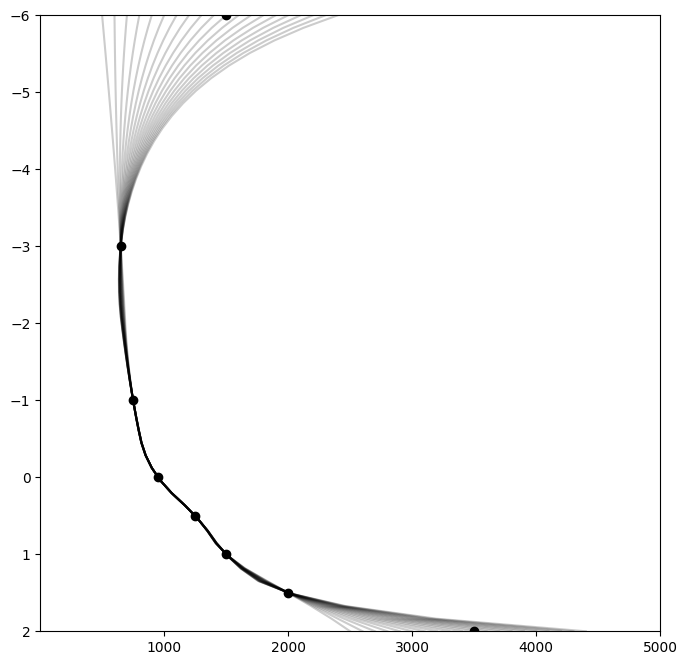

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

#T_knots = np.array([2000,1500,1250,950,750,750])
#T_knots = np.array([2000,1500,1250,950,750,1450])
#log_P_knots = np.array([1.5,1,0.5,0,-1,-3])

plt.figure(figsize=(8,8))

for T_i in np.arange(-1000,1000,100):

    T_knots = np.array([3500+T_i,2000,1500,1250,950,750,650,1500+T_i])
    log_P_knots = np.array([2,1.5,1,0.5,0,-1,-3,-6])

    knots, coeffs, deg = splrep(log_P_knots[::-1], np.log10(T_knots[::-1]), k=2)

    temperature = 10**splev(np.linspace(-6,2,50), (knots, coeffs, deg))

    plt.plot(temperature, np.linspace(-6,2,50), c='k', alpha=0.2)

    if T_i == 0:
        plt.plot(T_knots, log_P_knots, 'ko')

plt.xlim(1,5000)
plt.ylim(2,-6)
#plt.xscale('log')
plt.show()


4.047359794947301
12 12 8
[1500.          513.20039261  651.15747265  820.18537351 1297.34794172
 1524.15551201 2140.4521568  3500.        ]

4.047359794947396
12 8 8
[1500.          513.20039261  651.15747265  820.18537351 1297.34794172
 1524.15551201 2140.4521568  3500.        ]
[-6.  -6.  -6.  -6.  -1.   0.   0.5  1.   2.   2.   2.   2. ]


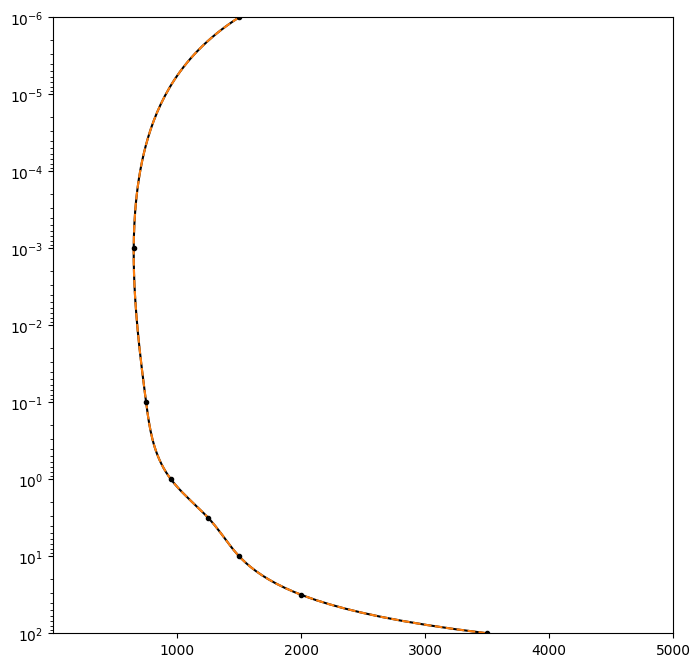

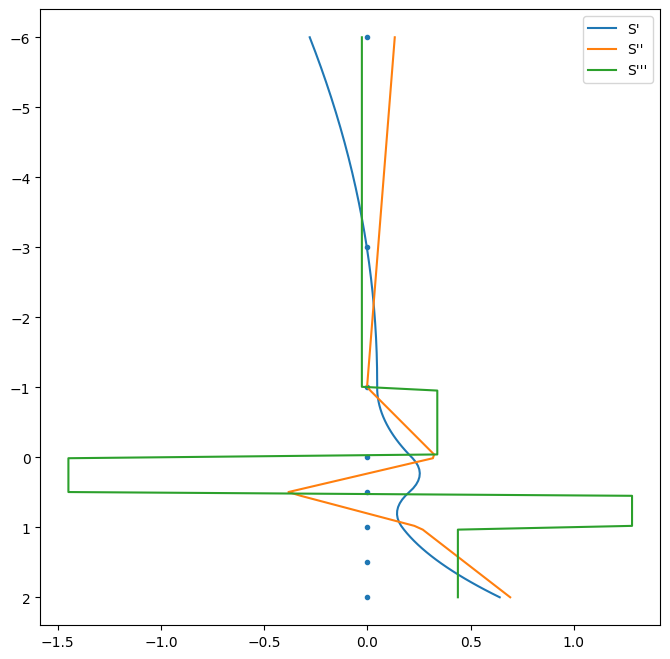

In [62]:
from scipy.interpolate import splev, splrep, make_interp_spline
import numpy as np
import matplotlib.pyplot as plt

def pen(knots, coeffs):
    # Compute the log-likelihood penalty based on the wiggliness
    # (Inverted) weight matrices, scaling the penalty of small/large segments
    inv_W_1 = np.diag(1/(1/3 * np.array([knots[i+3]-knots[i] \
                                        for i in range(1, len(knots)-4)]))
                    )
    inv_W_2 = np.diag(1/(1/2 * np.array([knots[i+2]-knots[i] \
                                        for i in range(2, len(knots)-4)]))
                    )
    inv_W_3 = np.diag(1/(1/1 * np.array([knots[i+1]-knots[i] \
                                        for i in range(3, len(knots)-4)]))
                    )

    # Fundamental difference matrix
    delta = np.zeros((len(inv_W_1), len(inv_W_1)+1))
    delta[:,:-1] += np.diag([-1]*len(inv_W_1))
    delta[:,1:]  += np.diag([+1]*len(inv_W_1))

    # 1st, 2nd, 3rd order general difference matrices
    D_1 = np.dot(inv_W_1, delta)
    D_2 = np.dot(inv_W_2, np.dot(delta[1:,1:], D_1))
    D_3 = np.dot(inv_W_3, np.dot(delta[2:,2:], D_2))

    gen_diff_penalty = np.nansum(np.dot(D_3, coeffs)**2)
    return gen_diff_penalty


plt.figure(figsize=(8,8))

pressure = np.logspace(-6,2,150)

T_knots = np.array([1500,650,750,950,1250,1500,2000,3500])
#T_knots = np.array([700,1900,750,950,1250,1500,2000,3500])
P_knots = 10**np.array([-6,-3,-1,0,0.5,1,1.5,2])

# Splrep
knots, coeffs, deg = splrep(np.log10(P_knots), np.log10(T_knots))
#knots = np.insert(knots, 4, np.log10(P_knots)[1])
#knots = np.insert(knots, -4, np.log10(P_knots)[-2])
#print(knots)
#print(coeffs)
#coeffs = np.insert(coeffs, 1, coeffs[1])
#coeffs = np.insert(coeffs, -5, coeffs[-6])
#print(coeffs)

temperature = 10**splev(np.log10(pressure), (knots, coeffs, deg), der=0)
plt.plot(temperature, pressure, c='k')

print(pen(knots, coeffs[:-4]))
print(len(knots), len(coeffs), len(coeffs[:len(knots)-4]))
print(10**coeffs[:len(knots)-4])
print()

#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots))
t = np.concatenate((np.ones(3)*np.log10(P_knots)[0], np.log10(P_knots), np.ones(3)*np.log10(P_knots)[-1]))
t = np.delete(t, obj=[4,-5])

spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), t=t, bc_type='not-a-knot')
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(1,0)],[(1,0)]))
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(2,0)],[(2,0)]))
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(3,0)],[(3,0)]))
#spl = make_interp_spline(np.log10(P_knots), np.log10(T_knots), bc_type=([(4,0)],[(4,0)]))
temperature = 10**spl(np.log10(pressure))
plt.plot(temperature, pressure, 'C1--')

knots, coeffs = spl.t, spl.c
print(pen(knots, coeffs))
print(len(knots), len(coeffs), len(coeffs[:len(knots)-4]))
print(10**coeffs)
print(knots)

plt.plot(T_knots, P_knots, 'k.')

plt.xlim(1,5000)
plt.yscale('log')
#plt.ylim(1e2,1e1)
plt.ylim(1e2,1e-6)
#plt.xscale('log')
plt.savefig('./plots/PT_interp.pdf')
plt.show()

plt.figure(figsize=(8,8))
#plt.plot(spl(np.log10(pressure), 0), np.log10(pressure))
#plt.plot(np.log10(T_knots), np.log10(P_knots), 'C0.')
plt.plot(np.log10(T_knots)*0, np.log10(P_knots), 'C0.')
plt.plot(spl(np.log10(pressure), 1), np.log10(pressure), label="S'")
plt.plot(spl(np.log10(pressure), 2), np.log10(pressure), label="S''")
plt.plot(spl(np.log10(pressure), 3), np.log10(pressure), label="S'''")
plt.legend()
plt.gca().invert_yaxis()
plt.show()